# Ensemble Hyperparams

<AxesSubplot:xlabel='Rho', ylabel='Distinctiveness'>

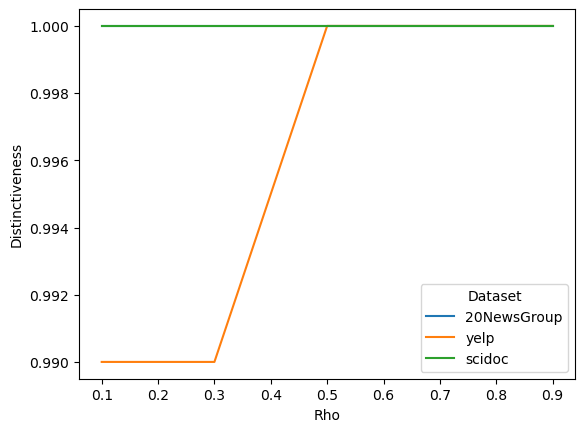

In [29]:
from glob import glob
import json
import seaborn as sns
from pathlib import Path
import json
import numpy as np
import re
import pandas as pd
DATASET='20NewsGroup'
RUN_DIR = 'ensemble'

FN_MATCHER = r'local-(?P<local>[0-9]\.[0-9])-global-(?P<global>[0-9]\.[0-9])-rho-(?P<rho>[0-9]\.[0-9]).json'
RESULTS_DIR = Path('./results') / DATASET / 'evaluations' / RUN_DIR
PLOTS_OUTPUT_DIR = RESULTS_DIR / 'plots'
PLOTS_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)


def parse_ensemble_results(*datasets):
    results = {
        "Dataset": [],
        "Local Weight": [],
        "Global Weight": [],
        "Rho": [],
        "PMI": [],
        "NPMI": [],
        "Distinctiveness": [],
    }
    for dataset in datasets:
        results_dir = Path('./results') / dataset / 'evaluations' / RUN_DIR
        files = list(results_dir.glob('local-*.json'))
        for i, filename in enumerate(files):
            matches = re.search(FN_MATCHER, str(filename))
            f = open(filename, 'r')
            data = json.load(f)
            f.close()
            results['Global Weight'].append(float(matches.group('global')))
            results['Local Weight'].append(float(matches.group('local')))
            results['Rho'].append(float(matches.group('rho')))
            results['PMI'].append(float(data['scores']['pmi']))
            results['NPMI'].append(float(data['scores']['npmi']))
            results['Distinctiveness'].append(float(data['scores']['distinctiveness']))
            results['Dataset'].append(dataset)
    df = pd.DataFrame(
        results,
    )
    return df
df = parse_ensemble_results('20NewsGroup', 'yelp', 'scidoc')
sns.lineplot(df[(df['Local Weight'] == 0.5 ) & (df['Global Weight'] == 0.5)], x='Rho', y='Distinctiveness', hue='Dataset')

In [23]:
df[(df.local_weight == 0.5 )& (df.global_weight == 0.5)]

AttributeError: 'DataFrame' object has no attribute 'local_weight'

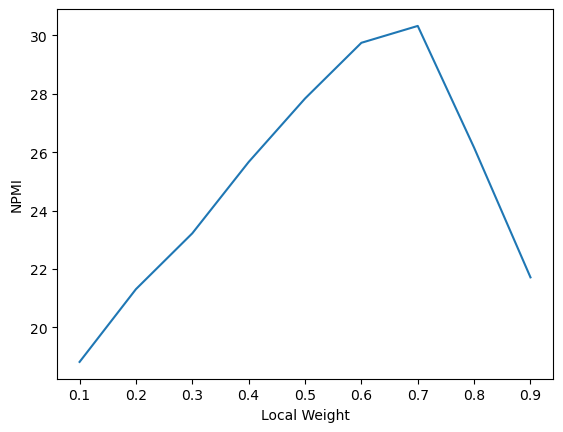

In [27]:
df[df.rho == 0.5].sort_values('local_weight').plot.line('local_weight',
                                                        y='npmi',
                                                        legend=None)
plt.ylabel('NPMI')
plt.xlabel('Local Weight')
plt.savefig(PLOTS_OUTPUT_DIR / 'weight-npmi.png')


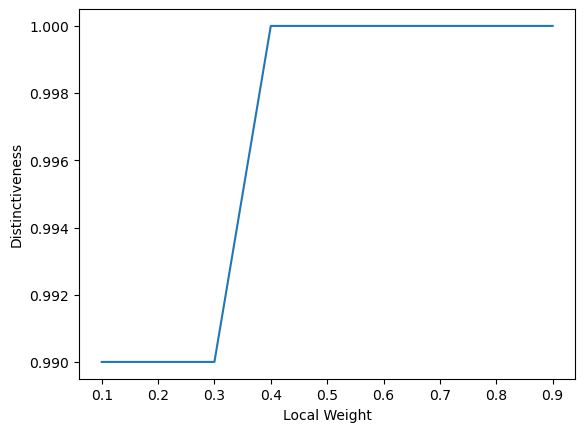

In [28]:
df[df.rho == 0.5].sort_values('local_weight').plot.line('local_weight',
                                                        y='distinctiveness',
                                                        legend=None)
plt.ylabel('Distinctiveness')
plt.xlabel('Local Weight')
plt.savefig(PLOTS_OUTPUT_DIR / 'weight-distinctiveness.png')

# Evaluation By methods

In [16]:
import os
import json
import pandas as pd

def result_json2dataset(datasets):
    from os.path import join as j
    results = {
        "dataset": [],
        "method": [],
        "metric": [],
        "score": [],
    }

    for dataset in datasets:
        metrics =['pmi', 'distinctiveness']
        evaluation_root = f"./results/{dataset}/evaluations/"
        methods = [
            # ('CaTE', j(evaluation_root, 'cate.json')),
            # ('Finetuned BERT', j(evaluation_root, 'finetuned-bert.json')),
            # ('Pretrained BERT', j(evaluation_root, 'pretrained-bert.json')),
            # ('SeededLDA', j(evaluation_root, 'seeded_lda.json')),
            (
                'EnsembleTM',
                j(evaluation_root, 'ensemble',
                  'local-0.5-global-0.5-rho-0.5.json'),
            ),
            (
                'EnsembleTM (Rank Reduced)',
                j(evaluation_root, 'evaluation_reduced',
                  'local-0.5-global-0.5-rho-0.5.json'),
            ),
        ]
        for method, file in methods:
            try:
                f = open(file, 'r')
                result = json.load(f)
                f.close()
                if len(result.keys()) == 1:
                    key = list(result.keys())[0]
                    result = result[key]

                for metric in metrics:
                    results['dataset'].append(dataset)
                    results['method'].append(method)
                    results['metric'].append(metric)
                    results['score'].append(result[metric])
            except FileNotFoundError:
                for metric in metrics:
                    results['dataset'].append(dataset)
                    results['method'].append(method)
                    results['metric'].append(metric)
                    results['score'].append(None)
    df = pd.DataFrame(results)
    return df
results = result_json2dataset(['20NewsGroup', 'scidoc', 'yelp'])
results

,dataset,method,metric,score
0,20NewsGroup,EnsembleTM,pmi,198.023006
1,20NewsGroup,EnsembleTM,distinctiveness,1.000000
2,20NewsGroup,EnsembleTM (Rank Reduced),pmi,179.319389
3,20NewsGroup,EnsembleTM (Rank Reduced),distinctiveness,1.000000
4,scidoc,EnsembleTM,pmi,94.854134
5,scidoc,EnsembleTM,distinctiveness,1.000000
6,scidoc,EnsembleTM (Rank Reduced),pmi,96.032597
7,scidoc,EnsembleTM (Rank Reduced),distinctiveness,1.000000
8,yelp,EnsembleTM,pmi,128.709250
9,yelp,EnsembleTM,distinctiveness,1.000000


<AxesSubplot:xlabel='dataset', ylabel='score'>

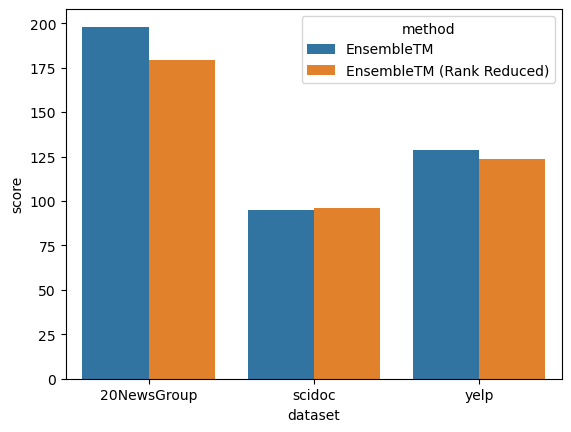

In [15]:
import seaborn as sns
sns.barplot(results[results.metric == 'pmi'], x='dataset', y='score', hue='method')

# In Vocab Vs Out Vocab

In [13]:
import os
from scripts.utils.io import load_seed
import re
import pandas as pd
import seaborn as sns
MATCHER = r'(?P<seed>[a-z_]+):(?P<pmi>[0-9.]*)'
def txt_output2dataframe(*datasets):
    # load seeds
    data = {
        "Dataset": [],
        "Type": [],
        "PMI": []
    }
    for dataset in datasets:

        dataset_result = {
            "In vocabulary Average": 0,
            "Out Vocabulary Average": 0,
            "Overall Average": 0,
        }
        seed_path = os.path.join('./data', dataset, 'seeds.json')
        result_path = os.path.join('./results/', dataset, 'evaluations', 'ensemble_pmi.txt')
        in_vocab, out_vocab = load_seed(seed_path, False)
        f = open(result_path, 'r')
        lines = f.readlines()
        f.close()
        pmis = ensemble_pmi2dict(lines)
        out_vocab_pmi = sum(pmis[word] for word in out_vocab) / len(in_vocab)
        in_vocab_pmi = sum(pmis[word] for word in in_vocab) / len(out_vocab)
        dataset_result['In vocabulary Average'] = in_vocab_pmi
        dataset_result['Out Vocabulary Average'] = out_vocab_pmi
        dataset_result['Overall Average'] = (in_vocab_pmi + out_vocab_pmi) / len(pmis)
        for key, value in dataset_result.items():
            data['Dataset'].append(dataset)
            data['Type'].append(key)
            data['PMI'].append(value)
    print(data)
    return pd.DataFrame(data)

def ensemble_pmi2dict(lines):
    res = {}
    for line in lines:
        match = re.match(MATCHER, line)
        match = match.groupdict()
        seed = match['seed']
        pmi = match['pmi']
        res[seed] = float(pmi)

    return res
df = txt_output2dataframe('scidoc', '20NewsGroup', 'yelp')

/home/alexzhang/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'Dataset': ['scidoc', 'scidoc', 'scidoc', '20NewsGroup', '20NewsGroup', '20NewsGroup', 'yelp', 'yelp', 'yelp'], 'Type': ['In vocabulary Average', 'Out Vocabulary Average', 'Overall Average', 'In vocabulary Average', 'Out Vocabulary Average', 'Overall Average', 'In vocabulary Average', 'Out Vocabulary Average', 'Overall Average'], 'PMI': [206.22535668195593, 2.0447822840852665, 18.933648996912837, 368.42529595053475, 27.62071624641767, 39.60460121969524, 217.31792971154928, 40.100569581403036, 25.741849929295235]}


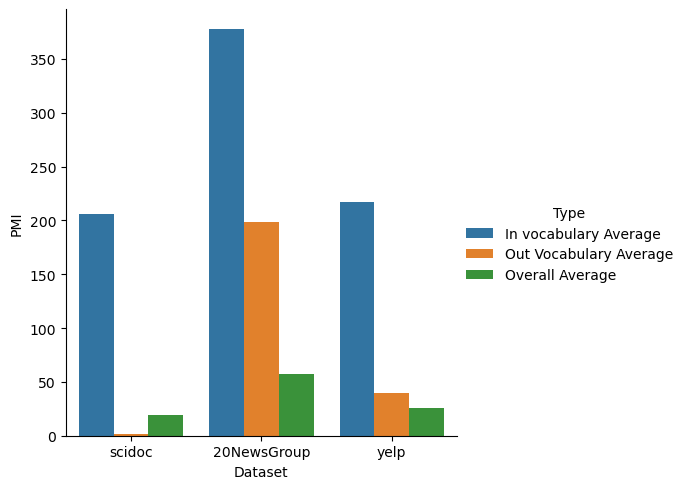

In [27]:
sns.catplot(df,
            kind='bar',
            x='Dataset',
            y='PMI',
            hue='Type')


In [12]:
import pandas as pd

pd.read_pickle('./results/20NewsGroup/bert/similarities_reduced.pkl')

,religion,hardware,space,gun,medicine,crypt,graphics,sports,politics,windows
a_man_for_all_seasons,0.484393,0.738237,0.633260,0.559287,0.572509,0.676333,0.719407,0.761639,0.666247,0.571533
aa,0.435599,0.557438,0.493869,0.507228,0.449746,0.503522,0.551282,0.549799,0.457013,0.500144
aaa,0.413712,0.537918,0.495697,0.489367,0.443494,0.535385,0.514829,0.527140,0.460841,0.504183
aaaaa,0.348351,0.444227,0.399630,0.434262,0.379694,0.462129,0.436600,0.431248,0.378799,0.433911
aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaauuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuugggggggggggggggg,0.295177,0.374113,0.368627,0.351624,0.294708,0.378614,0.362699,0.314556,0.259483,0.372591
...,...,...,...,...,...,...,...,...,...,...
zvi,0.317077,0.375345,0.420776,0.346089,0.345079,0.461395,0.428786,0.416634,0.374201,0.432856
zvonko,0.265822,0.225852,0.311160,0.260114,0.283317,0.303111,0.255705,0.286833,0.252356,0.300166
zwischen,0.277496,0.275638,0.334692,0.308929,0.300079,0.354774,0.296417,0.303538,0.247493,0.341380
zyda,0.256962,0.281581,0.365780,0.286798,0.304965,0.382398,0.324749,0.328240,0.300909,0.366718
